In [50]:
import numpy as np 
from scipy.special import erf, erfc
import matplotlib.pyplot as plt 
from scipy.integrate import trapz

In [217]:
t = np.linspace(0, 5 * 60 * 60, 10000) 
dt = t[1] - t[0]
tc = (t[1:] + t[:-1]) / 2.0 

# step function

In [229]:
# step function starting at 5 minutes
sigma = 1e6 *  (1 +  erf((t - 60*5)/15))/2 - 1e6 

# applied constant from 5 to 60 mins
sigma = 1e6 *  (1 +  erf((t - 60*5)/15))/2 - 1e6 *  (1 +  erf((t - 60*60)/15))/2 

# oscillatory, starting at 5 mins
# omega = 0.0001
# sigma = (1e6 + 5e5 * np.sin(2 * np.pi * t  * omega)) *  (1 +  erf((t - 60*5)/15))/2


In [230]:

dsigma_dt = (sigma[1:] - sigma[:-1]) / dt

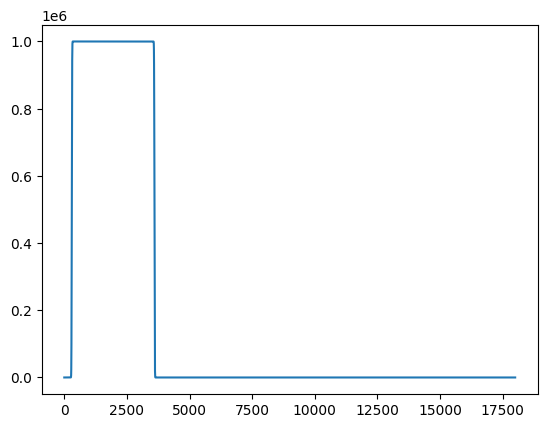

In [231]:
plt.plot(t, sigma)
# plt.xlim([0, 500])

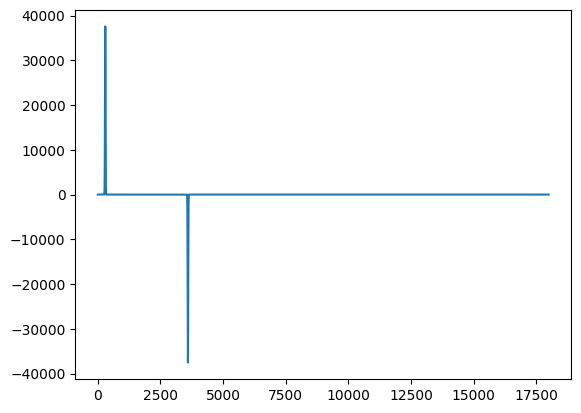

In [232]:
plt.plot(tc, dsigma_dt)
# plt.xlim([0, 500])

In [233]:
E =  1e10
eta = 1e14

In [234]:
strain = np.zeros((t.size - 1))
for i_t, t_i in enumerate(t[:-1]): 

    if i_t == 0: 
        continue 

    timerange = t[0:i_t]
    t_diff = t_i -timerange

    # maxwell
    Jmax = 1/ E + t_diff / eta * (t_diff > 0 )

    # voigt 
    trelax = eta / E 
    Jvoigt = 1/E * (1 - np.exp(-t_diff/trelax)* (t_diff > 0 ))

    # voigt + maxwell
    J = Jmax + Jvoigt

    dsigma = dsigma_dt[0:i_t]

    integrand = J * dsigma    
    strain[i_t] = trapz(integrand, timerange)

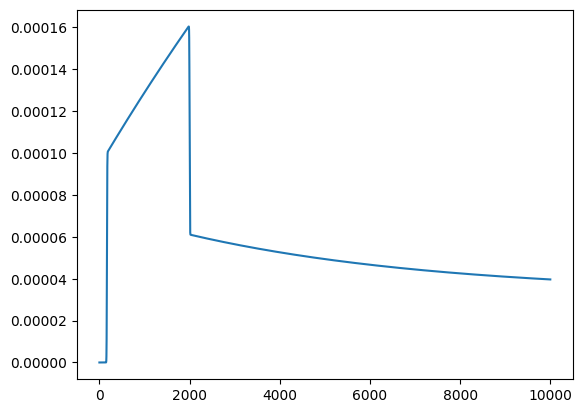

In [235]:
plt.plot(strain)
# plt.xlim([0, 1000])

In [191]:
strain.max() - strain[-1]

5.073279128491964e-05

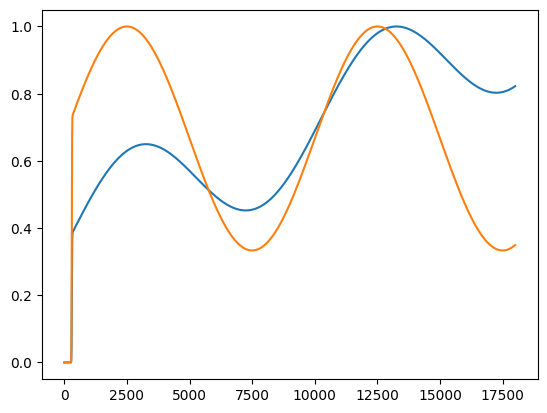

In [193]:
plt.plot(tc, strain/strain.max())
plt.plot(t, sigma/sigma.max())